In [1]:
import numpy as np
import pandas as pd
import glob
import os
import json
import anndata
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Analysis.__init__plots import *
from dredFISH.Analysis import basicu

In [2]:
def normalize_w(W, num_tp=90000):
    """Normalize the matrix W from DPNMF
    - scale 
    - integerize
    - remove genes with no weights
    """
    # scale
    Wn = W/(W.sum().sum())*num_tp
    # integerize 
    Wn = (Wn+0.5).astype(int)
    # remove genes with no weights
    nonzero_cond = Wn.sum(axis=1)>0  
    
    Wn_slim = Wn.loc[nonzero_cond]
    
    print(f"Total num probes: {Wn.sum().sum():,}")
    print(f"Total num genes: {nonzero_cond.sum():,}")
    return Wn, Wn_slim, nonzero_cond

In [3]:
def normalize_w_v2(W, cnstrnts, num_tp=90000):
    """Normalize the matrix W from DPNMF
    - scale 
    - integerize
    - cap probe constraints
    - remove genes with no weights
    
    arguments:
    - W: DataFrame
    """
    assert len(W) == len(cnstrnts)
    
    # scale
    Wn = W/(W.sum().sum())*num_tp
    # integerize 
    Wn = (Wn+0.5).astype(int)
    # constraints
    for col in Wn:
        Wn[col] = np.clip(Wn[col], None, cnstrnts)
    # remove genes with no weights
    nonzero_cond = Wn.sum(axis=1)>0  
    
    Wn_slim = Wn.loc[nonzero_cond]
    
    print(f"Total num probes: {Wn.sum().sum():,}")
    print(f"Total num genes: {nonzero_cond.sum():,}")
    return Wn, Wn_slim, nonzero_cond

In [4]:
def plot_W(Wn_slim, ax, reorder_genes=True, style='v'):
    Wn_slim = np.array(Wn_slim)
    if reorder_genes:
        _mat, _row, _col = basicu.diag_matrix_rows(Wn_slim)
    else:
        _mat = Wn_slim
    m, n = _mat.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Mean num probes', orientation='horizontal', pad=0.05)

    sns.heatmap(
                pd.DataFrame(_mat), 
                cmap='rocket_r',
                ax=ax, 
                cbar_kws=cbar_kws,
                rasterized=True,
                norm=matplotlib.colors.LogNorm(),
               )
    ax.set_xlabel('Basis')
    ax.set_ylabel('Genes')

    ax.set_xticks([n])
    ax.text(n, m, n, ha='center', va='top')

    ax.set_yticks([m])
    ax.text(0, m, m, ha='right', va='center')
    
    return _mat, _row

def plot_Sc(Sc, ax, style='v', **kwargs):
    """
    """
    m, n = Sc.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Mean num probes', orientation='horizontal', pad=0.05)
    
    sns.heatmap(Sc, 
                xticklabels=5,
                cmap='coolwarm', 
                norm=matplotlib.colors.LogNorm(),
                cbar_kws=cbar_kws,
                ax=ax,
                **kwargs,
               )
    # ax.set_xticks([n])
    # ax.text(n, m, n, ha='center', va='top')
    
def plot_Scn(Scn, ax, style='v', **kwargs):    
    """
    """
    m, n = Scn.shape
    
    if style == 'v':
        cbar_kws = dict(shrink=0.5, label='Zscored mean num probes')
    elif style == 'h':
        cbar_kws = dict(shrink=0.8, label='Zscored mean num probes', orientation='horizontal', pad=0.05)
        
    sns.heatmap(Scn, 
                xticklabels=5,
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                center=0,
                vmax=3,
                vmin=-3,
                ax=ax,
                **kwargs,
               )
    # ax.set_xticks([n])
    # ax.text(n, m, n, ha='center', va='top')
    
def plot_all_mats(Wn_slim, Sc, Spc, Scn, Spcn, title=""):
    """
    """
    with sns.axes_style('white'):
        fig, axs = plt.subplots(1, 5, figsize=(6*5,16))
        ax = axs[0]
        plot_W(Wn_slim, ax, style='h')
        ax.set_title(title)

        ax = axs[1]
        plot_Sc(Sc, ax, style='h', yticklabels=False)
        ax.set_title('Z (theory)')
        ax.set_ylabel('Cell types')

        ax = axs[2]
        plot_Sc(Spc, ax, style='h', yticklabels=False)
        ax.set_title('Z (corrected)')

        ax = axs[3]
        plot_Scn(Scn, ax, style='h', yticklabels=False)
        ax.set_title('Z (theory) normed')

        ax = axs[4]
        plot_Scn(Spcn, ax, style='h', yticklabels=l3clst_order)
        ax.set_title('Z (corrected) normed')
        ax.yaxis.tick_right()
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

        fig.subplots_adjust(wspace=0.1)
        plt.show()

In [5]:
ddir = "/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/"
!ls $ddir

smrt_X_all_cells.csv
smrt_X_all.npy
smrt_X_all_pnmfS_k24.csv
smrt_X_all_pnmfW_k24.csv
smrt_X_all_y_L3_dpnmfS_k24_mu0.csv
smrt_X_all_y_L3_dpnmfW_k24_mu0.csv
smrt_X_all_y_L3.npy
smrt_X_all_y_L5_dpnmfS_k24_mu0.csv
smrt_X_all_y_L5_dpnmfW_k24_mu0.csv
smrt_X_all_y_L5.npy
smrt_X_subL3n1000_cells.csv
smrt_X_subL3n1000.npy
smrt_X_subL3n1000_pnmfS_k24.csv
smrt_X_subL3n1000_pnmfW_k24.csv
smrt_X_subL3n1000_y_L3_dpnmfS_k24_mu0.csv
smrt_X_subL3n1000_y_L3_dpnmfW_k24_mu0.csv
smrt_X_subL3n1000_y_L3.npy
smrt_X_subL3n100_cells.csv
smrt_X_subL3n100.npy
smrt_X_subL3n100_pnmfS_k24.csv
smrt_X_subL3n100_pnmfW_k24.csv
smrt_X_subL3n100_y_L3_dpnmfS_k24_mu0.01.csv
smrt_X_subL3n100_y_L3_dpnmfS_k24_mu0.csv
smrt_X_subL3n100_y_L3_dpnmfS_k24_mu10000.csv
smrt_X_subL3n100_y_L3_dpnmfS_k24_mu100.csv
smrt_X_subL3n100_y_L3_dpnmfS_k24_mu1.csv
smrt_X_subL3n100_y_L3_dpnmfSsel_k24_mu10000.csv
smrt_X_subL3n100_y_L3_dpnmfW_k24_mu0.01.csv
smrt_X_subL3n100_y_L3_dpnmfW_k24_mu0.csv
smrt_X_subL3n100_y_L3_dpnmfW_k24_mu10000.csv
smrt_X_

# Get data

In [6]:
# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
    
l3clst_order = meta['l3_clsts'] # get cluster order

In [7]:
# read in data
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_count_matrix_v5.h5ad'
adata = anndata.read(f)#, backed='r')

# get the NN genes
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
tenx_genes = np.load(f)
nn_genes = tenx_genes

# get gene constraints
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/probe_constraints.npy'
cnstrnts = np.load(f)
assert len(cnstrnts) == len(nn_genes)

# Generate matrices 

In [8]:
setting_list = [
    ('All cells; PNMF', 'smrt_X_all_pnmfS_k24.csv', 'smrt_X_all_pnmfW_k24.csv', 'smrt_X_all_cells.csv'),
    
    ('subL3n10; PNMF', 'smrt_X_subL3n10_pnmfS_k24.csv', 'smrt_X_subL3n10_pnmfW_k24.csv', 'smrt_X_subL3n10_cells.csv'),
    ('subL3n100; PNMF', 'smrt_X_subL3n100_pnmfS_k24.csv', 'smrt_X_subL3n100_pnmfW_k24.csv', 'smrt_X_subL3n100_cells.csv'),
    ('subL3n1000; PNMF', 'smrt_X_subL3n1000_pnmfS_k24.csv', 'smrt_X_subL3n1000_pnmfW_k24.csv', 'smrt_X_subL3n1000_cells.csv'),
    
    ('subL5n10; PNMF', 'smrt_X_subL5n10_pnmfS_k24.csv', 'smrt_X_subL5n10_pnmfW_k24.csv', 'smrt_X_subL5n10_cells.csv'),
    ('subL5n100; PNMF', 'smrt_X_subL5n100_pnmfS_k24.csv', 'smrt_X_subL5n100_pnmfW_k24.csv', 'smrt_X_subL5n100_cells.csv'),
    ('subL5n1000; PNMF', 'smrt_X_subL5n1000_pnmfS_k24.csv', 'smrt_X_subL5n1000_pnmfW_k24.csv', 'smrt_X_subL5n1000_cells.csv'),
]

(73347, 24) (10861, 24) (73347,)
Total num probes: 88,317
Total num genes: 7,137
Total num probes: 76,744
Total num genes: 7,131


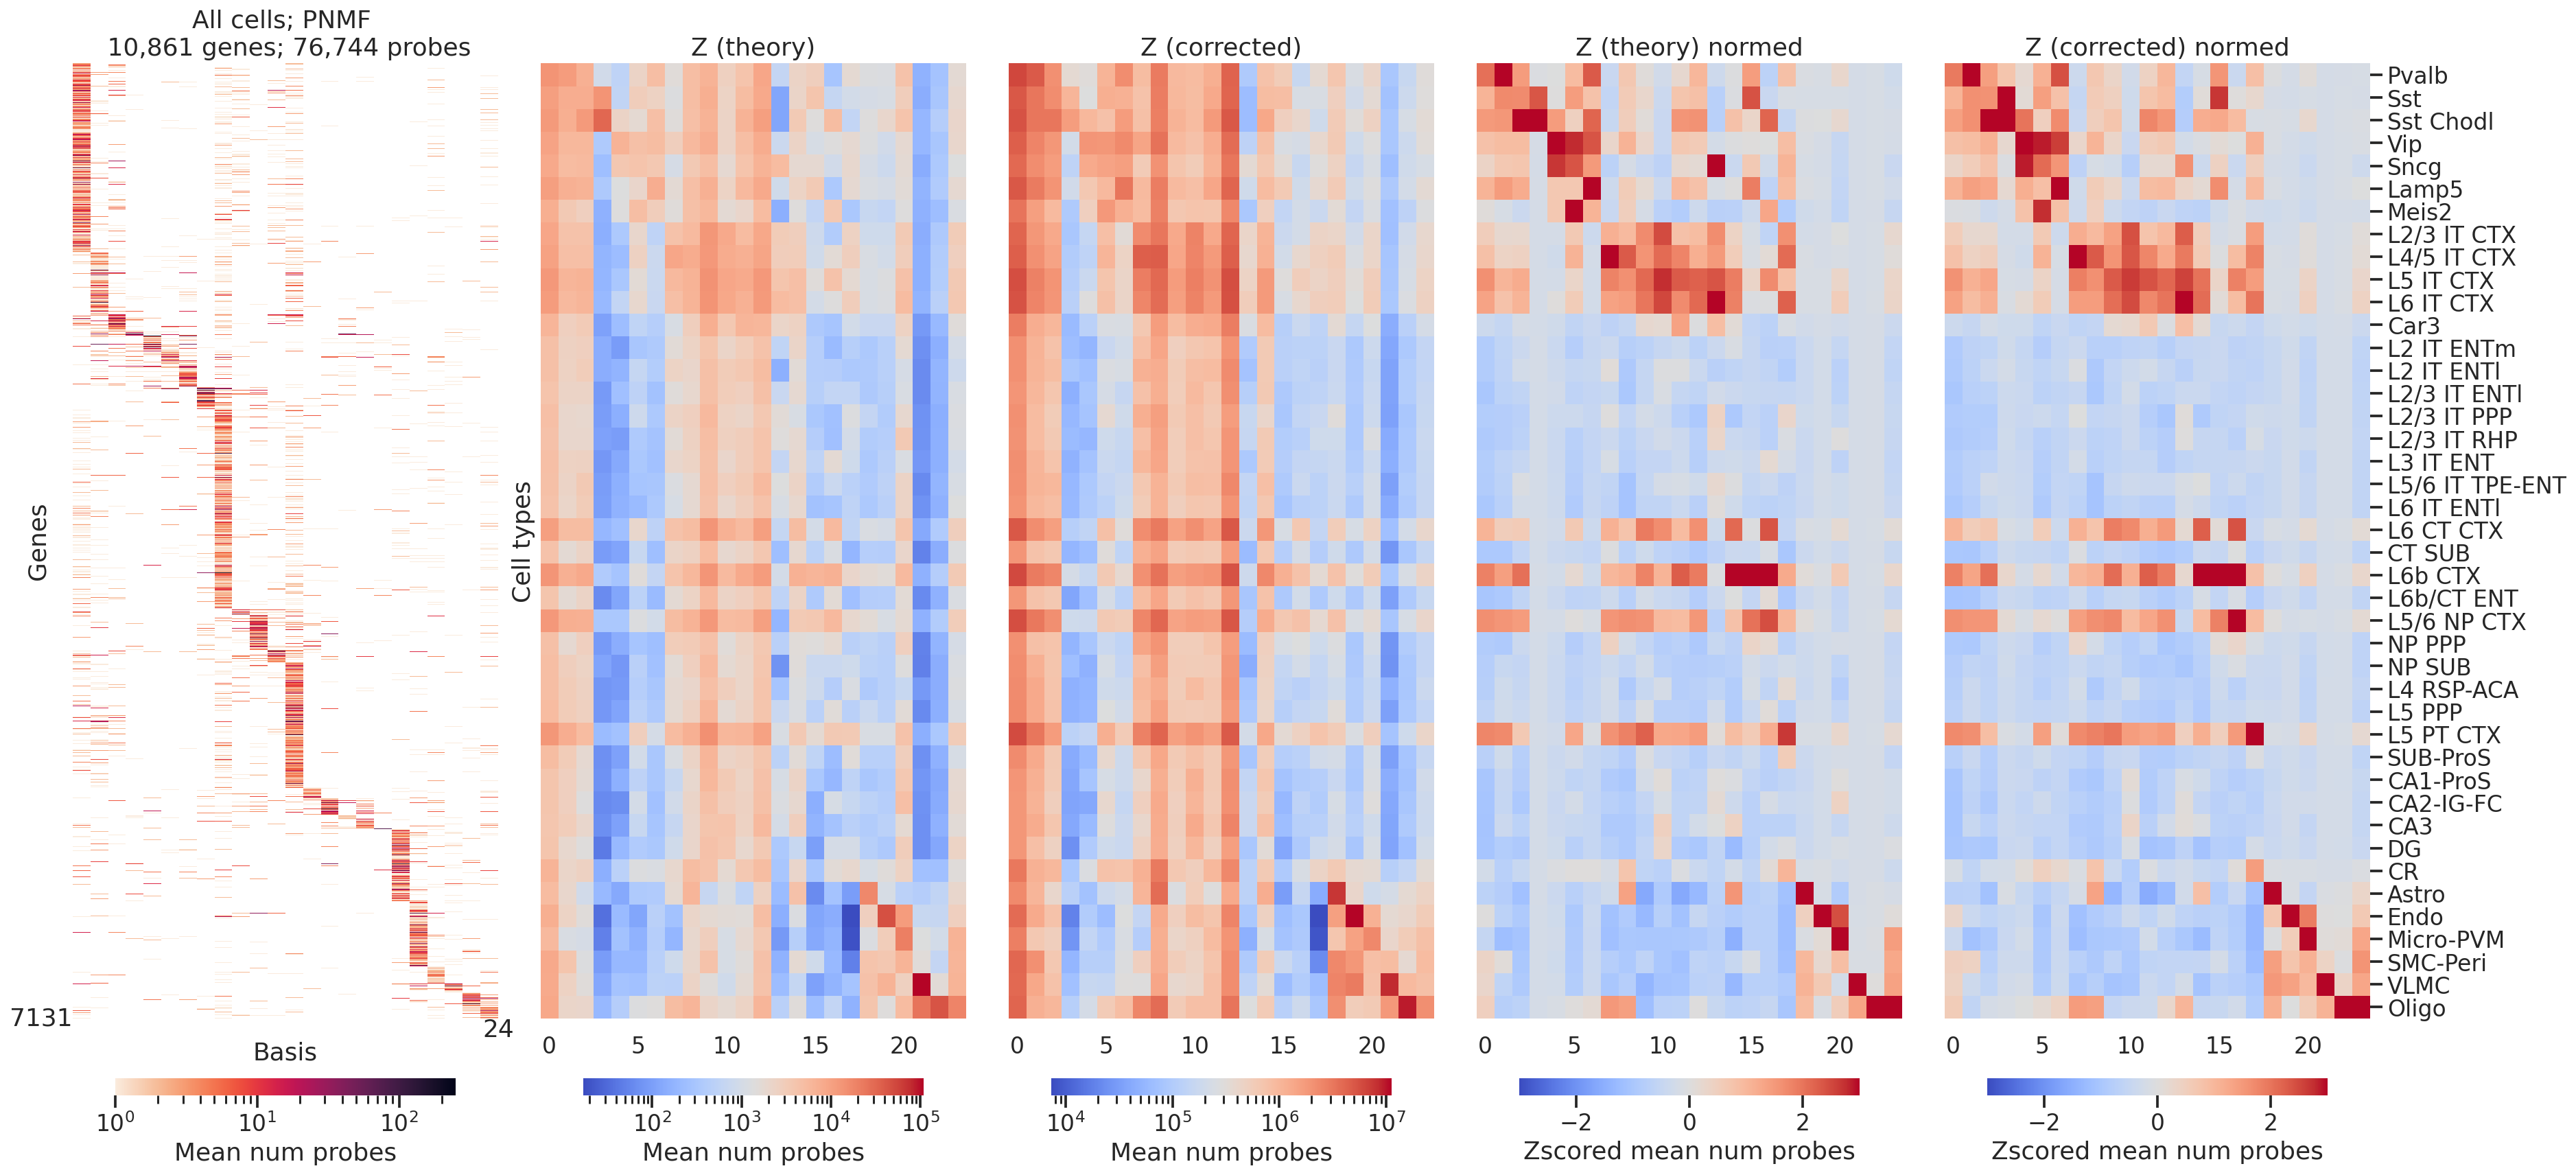

In [9]:
for setting in setting_list:
    ti = time.time()
    
    study, s_file, w_file, cell_file = setting
    #### data =====
    # get DPNMF results
    f = os.path.join(ddir, s_file)
    S = pd.read_csv(f, index_col=0)

    f = os.path.join(ddir, w_file)
    W = pd.read_csv(f, index_col=0)

    f = os.path.join(ddir, cell_file)
    cells = pd.read_csv(f, index_col=0)['0'].values
    print(S.shape, W.shape, cells.shape)

    # get annotations
    genes = nn_genes

    # get the data right
    adatasub = adata[cells, genes]
    cells_annot = adatasub.obs
    # print(f"{time.time()-ti:.2f}s")
    #### data =====

    # basis matrix
    Wn2, Wn_slim2, Wn_nzcond2 = normalize_w(W)
    Wn, Wn_slim, Wn_nzcond = normalize_w_v2(W, cnstrnts, num_tp=90000)

    # score matrix (theory)
    Sc, clsts = basicu.group_mean(S, cells_annot['subclass_label'].values, 
                                 group_order=l3clst_order)
    Scn = basicu.zscore(Sc, allow_nan=False, axis=0)

    # score matrix (corrected)
    Sp = adatasub.X.toarray().dot(Wn)
    Spc, clsts = basicu.group_mean(Sp, cells_annot['subclass_label'].values, 
                                  group_order=l3clst_order)
    Spcn = basicu.zscore(Spc, allow_nan=False, axis=0)
    # print(f"{time.time()-ti:.2f}s")
    
    # basis order (take quite long)
    Spcn_bo, _, basis_order = basicu.diag_matrix_cols(Spcn) # this takes quite long
    Scn_bo = Scn[:,basis_order]
    Spc_bo = Spc[:,basis_order]
    Sc_bo = Sc[:,basis_order]
    Wn_slim_bo = Wn_slim.iloc[:,basis_order]
    
    # Viz
    title = f"{study} \n {len(genes):,} genes; {Wn.sum().sum():,} probes"
    plot_all_mats(Wn_slim_bo, Sc_bo, Spc_bo, Scn_bo, Spcn_bo, title=title)
    # print(f"{time.time()-ti:.2f}s")
    
    break

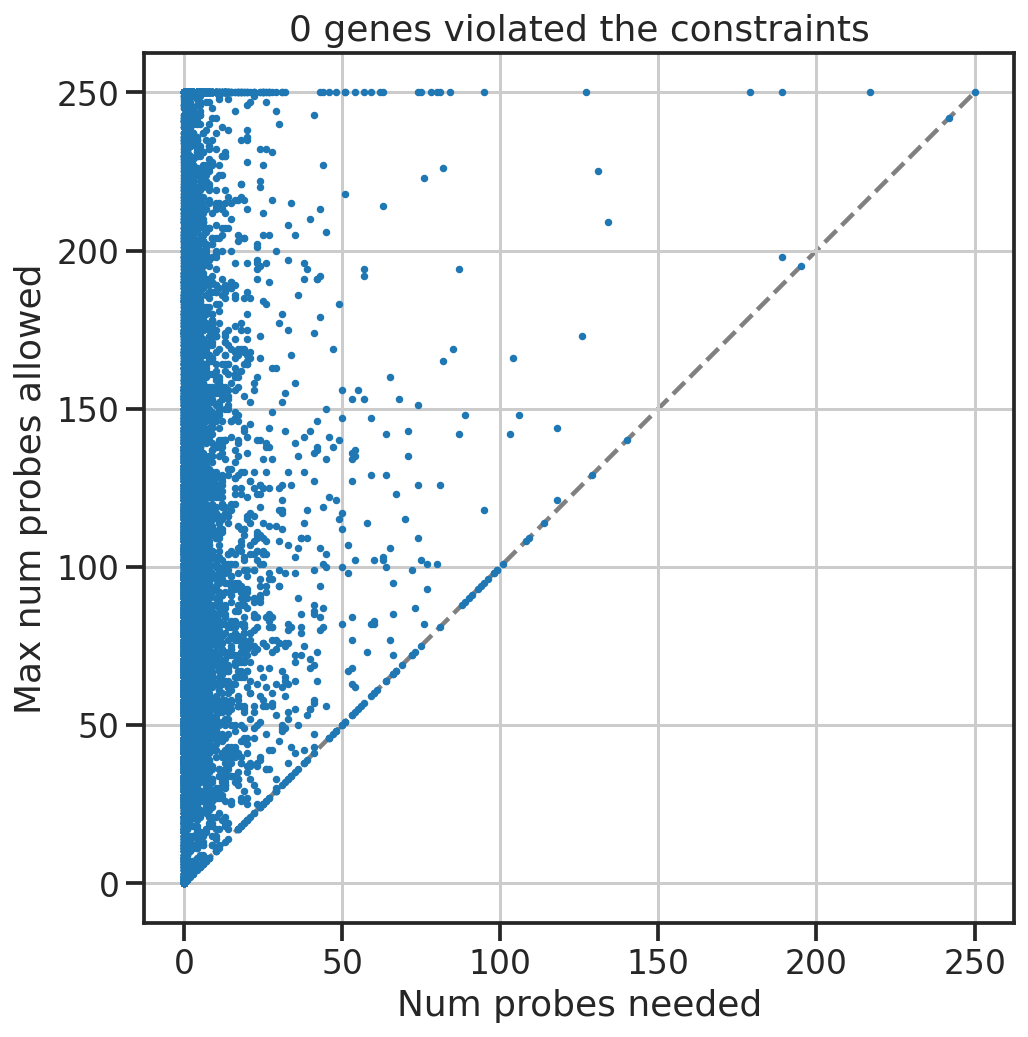

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
needed = Wn.max(axis=1).values
ax.scatter(
    needed,
    cnstrnts,
    s=5,
)
num_violated = np.sum(cnstrnts < needed)
ax.plot([0,250], [0, 250], '--', color='gray', zorder=0)
ax.set_aspect('equal')
ax.set_ylabel('Max num probes allowed')
ax.set_xlabel('Num probes needed')
ax.set_title(f'{num_violated} genes violated the constraints')
plt.show()

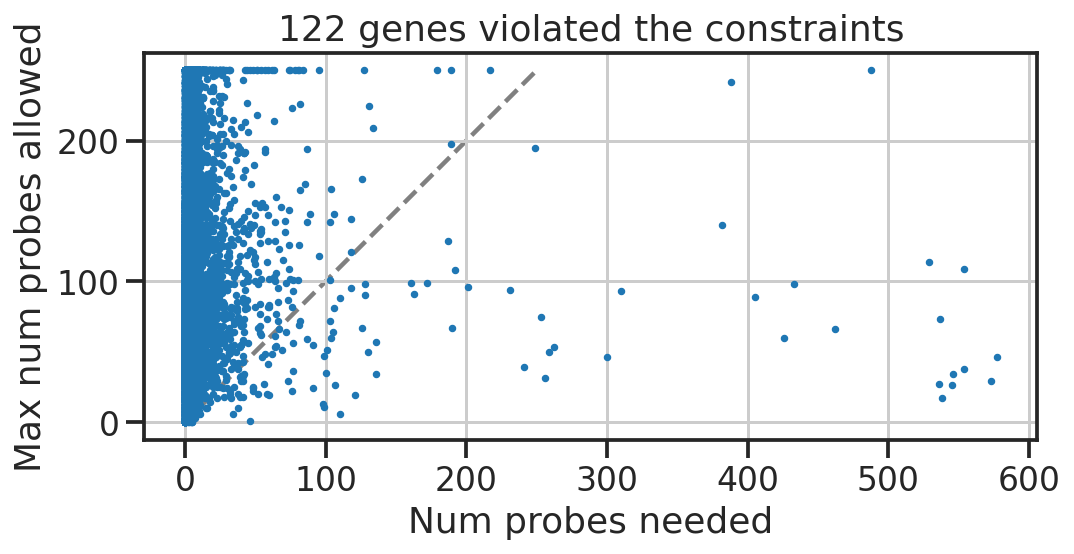

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
needed = Wn2.max(axis=1).values
ax.scatter(
    needed,
    cnstrnts,
    s=5,
)
num_violated = np.sum(cnstrnts < needed)
ax.plot([0,250], [0, 250], '--', color='gray', zorder=0)
ax.set_aspect('equal')
ax.set_ylabel('Max num probes allowed')
ax.set_xlabel('Num probes needed')
ax.set_title(f'{num_violated} genes violated the constraints')
plt.show()

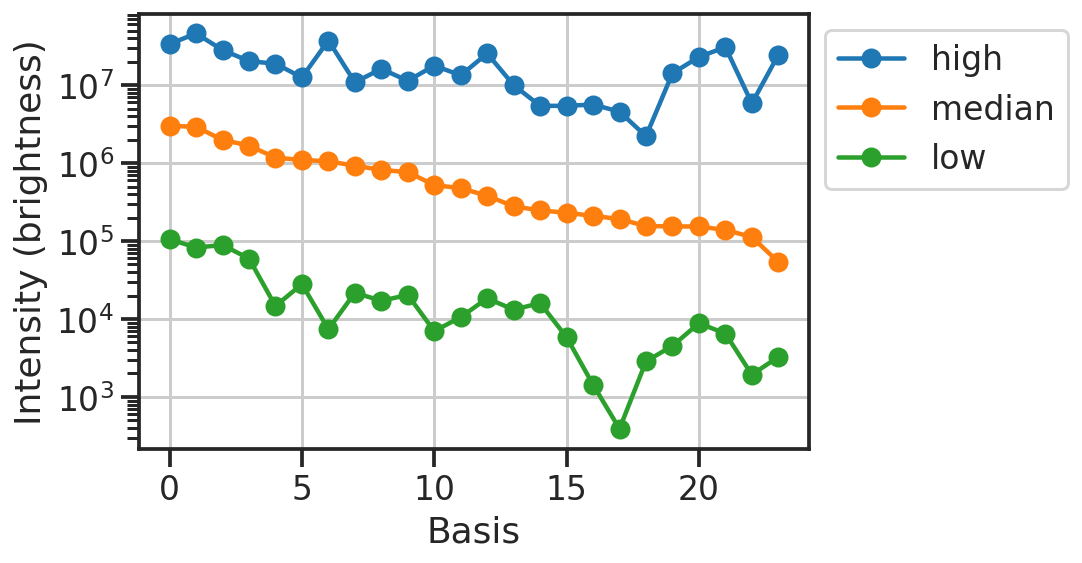

In [12]:
# brightness
med_intnst = np.median(Sp, axis=0)
low_intnst = np.min(Sp, axis=0)
high_intnst = np.max(Sp, axis=0)
order = np.argsort(med_intnst)[::-1]

fig, ax = plt.subplots()
ax.plot(high_intnst[order], '-o', label='high')
ax.plot(med_intnst[order], '-o', label='median')
ax.plot(low_intnst[order], '-o', label='low')
ax.set_xlabel('Basis')
ax.set_ylabel('Intensity (brightness)')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

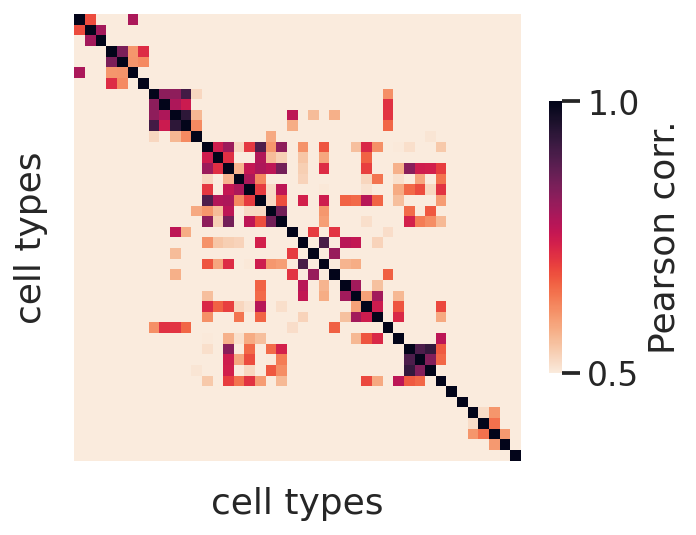

In [13]:
# correlation
corr = np.corrcoef(Spcn)
vmin = 0.5

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pd.DataFrame(corr, columns=l3clst_order, index=l3clst_order), 
            yticklabels=False,
            xticklabels=False,
            vmin=vmin, cmap='rocket_r', 
            cbar_kws=dict(shrink=0.5, ticks=[vmin, 1], label='Pearson corr.'),
            ax=ax)
ax.set_aspect('equal')
ax.set_xlabel('cell types')
ax.set_ylabel('cell types')
plt.show()